In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import bisect

In [135]:
# Warm up: European put option

# Define option price
def I(sigma, r=0.05, T=0.2, K=120, S0=100):
    wstar = (np.log(K/S0) - (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r*T) * K * norm.cdf(wstar) - S0 * norm.cdf(wstar - sigma * np.sqrt(T))

# Calculate the "true" implied volatility
I_m = 22
sigma_true = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_true)

0.508372926009589


In [170]:
# Robbins Monroe Algorithm
def Jhat(sigma, N=100, r=0.05, T=0.2, K=120, S0=100, I_market=22):
    W_T = norm.rvs(loc=0, scale=T, size=N)
    S_T = S0 * np.exp((r - sigma**2 / 2) * T + sigma * W_T)
    f = np.exp(-r*T) * (K - S_T)
    f[f < 0] = 0
    return np.mean(f) - I_market

def RM(Jhat, rho=0.8, N=100, n=100, iterations=100, K=120, S0=100):
    # N = Parameter in Monte Carlo estimator Jhat of f (stock payoff)
    # n = Number of iterations of RM algorithm
    # size = Number of times to run RM algorithm (for expectation)
    a0 = 2 / (K + S0)
    vals = []
    for _ in range(iterations):
        i = 0
        sigmas = np.empty((n,))
        sigmas[0] = 1
        while True:
            alpha_n = a0 / i**rho if i > 0 else a0
            sigma_cur = sigmas[i]
            sigmas[i+1] = sigma_cur - alpha_n * Jhat(sigma_cur, N=N, K=K, S0=S0)
            i+=1
            if i == n-1:
                break
        vals.append(sigmas)
    return np.array(vals)

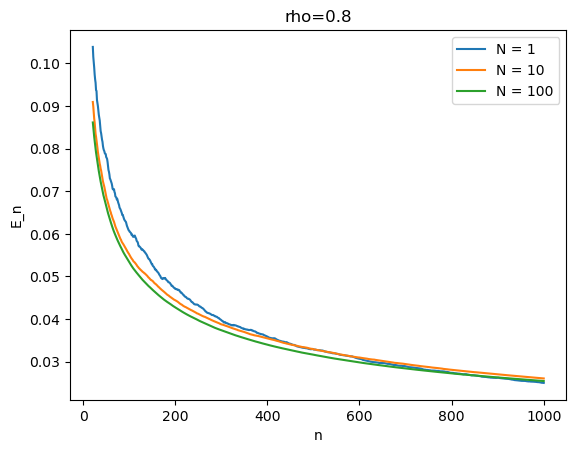

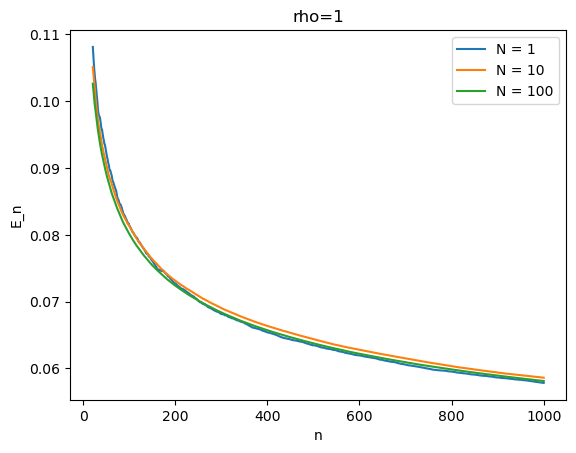

In [171]:
# Estimate MSE
for rho in [0.8,1]:
    plt.figure()
    plt.title('rho=' + str(rho))
    for N in [1,10,100]:
        n = 1000
        sigmahats = RM(Jhat, rho=rho, N=N, n=int(n), iterations=100)
        plt.plot(np.arange(21, n+1), np.mean((sigmahats - sigma_true)**2, axis=0)[20:], label='N = ' + str(N))
    plt.legend()
    plt.xlabel('n')
    plt.ylabel('E_n')

In [158]:
# Asian put option
def Jhat_asian(sigma, N=100, m=50, r=0.05, T=0.2, S0=100, K=120, I_market=22):
    S_avg = np.zeros(N)
    for j in range(N):
        W = np.zeros(m+1)
        for i in range(1,m+1):
            delta = norm.rvs(loc=0, scale=T/m)
            W[i] = W[i-1] + delta
        S = S0 * np.exp((r - sigma**2 / 2) * np.arange(1,m+1)*T/m + sigma * W[1:])
        S_avg[j] = np.mean(S)
    f = np.exp(-r*T) * (K - S_avg)
    f[f < 0] = 0
    return np.mean(f) - I_market

def RM_convergence(Jhat, rho=0.8, n=100, S0=100, K=120):
    # N = Parameter in Monte Carlo estimator Jhat of f (stock payoff)
    # n = Number of iterations of RM algorithm
    
    a0 = 2 / (K + S0)
    i = 0
    sigmas = np.empty((n,))
    sigmas[0] = 1
    while True:
        alpha_n = a0 / i**rho if i > 0 else a0
        sigma_cur = sigmas[i]
        sigmas[i+1] = sigma_cur - alpha_n * Jhat(sigma_cur, K=K, S0=S0)
        i+=1
        if i == n-1:
            break
    return sigmas

Text(0, 0.5, 'sigma')

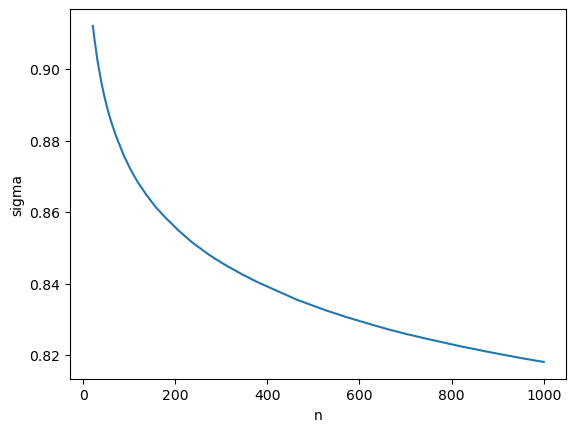

In [161]:
n=1000
sigmas = RM_convergence(Jhat_asian, n=n)
plt.plot(range(21,n+1), sigmas[20:])
plt.xlabel('n')
plt.ylabel('sigma')

In [131]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

Old bounds for I_market: (19.294367043657672, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


In [132]:
# Question 6: Important Sampling

# Part a) Use IS to approximate I(sigma). Note: Jhat(sigma) = I(sigma) - I_market

def Jhat_asian_IS(sigma, N=100, m=50, r=0.05, r_tilde=0.001, T=0.2, S0=100, K=80, I_market=10):
    S_avg = np.zeros(N)
    S_avg_tilde = np.zeros(N)
    for j in range(N):
        W = np.zeros(m+1)
        for i in range(1,m+1):
            delta = norm.rvs(loc=0, scale=T/m)
            W[i] = W[i-1] + delta
        S = S0 * np.exp((r - sigma**2 / 2) * np.arange(1,m+1)*T/m + sigma * W[1:])
        S_tilde = S0 * np.exp((r_tilde - sigma**2 / 2) * np.arange(1,m+1)*T/m + sigma * W[1:])
        S_avg[j] = np.mean(S)
        S_avg_tilde[j] = np.mean(S_tilde)
    
    f = np.exp(-r_tilde*T) * (K - S_avg_tilde)
    f[f < 0] = 0
    
    # Pg 61 notes -> Should it be S_T_tilde instead of S_T ????
    mu = np.mean(f * (S_avg / S0)**((- r_tilde + r)/(sigma**2)) * np.exp(((r_tilde - r)*(r_tilde + r - sigma**2)*T)/(2*sigma**2)))
    return mu - I_market

In [ ]:
# Quantify variance reduction in using r_tilde = 0.001 ????

Text(0, 0.5, 'sigma')

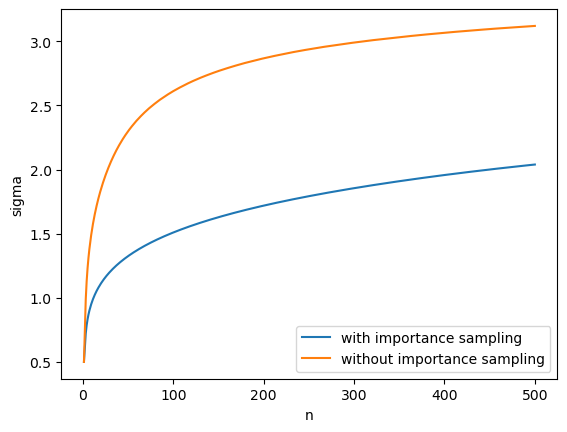

In [133]:
# Part b) Compare RM algorithm with and without importance sampling
n=500
sigmas_IS = RM_convergence(Jhat_asian_IS, n=n, K=80)
plt.plot(range(1,n+1), sigmas_IS, label='with importance sampling')

sigmas = RM_convergence(Jhat_asian, n=n, K=80)
plt.plot(range(1,n+1), sigmas, label='without importance sampling')
plt.legend()
plt.xlabel('n')
plt.ylabel('sigma')